# Playing *gomoku*: Learning an after-state value function

This program learns a value-function $\hat{v}(s,\theta)$ that approximates the value (expected future rewards) of an 'after-state' $s(S,a)$, where $S$ is the state at which the action $a$ is taken. An afterstate follows an action but is not taking the full update of the environment into account. If the afterstate is deterministic but the full update is stochastic, the afterstate can be used to evaluate possible actions. In this case the afterstate is the playing board in a game of *gomoku* ('*connect 5*' or '*luffarschack*'), just after Player's move, but before Opponent's move. Learning such a value-function is more efficient than Q-learning or similar, since many state-actions can lead to the same afterstate. This approach also takes fully into account what is known about the environment, which a regular q-function or parameterized policy would not. The downside is that several possible afterstates have to be evaluated for each move.

The corresponding policy $\pi(a|S,\theta)$ is given by $\underset{a}{\mathrm{argmax}}\ \hat{v}(s(S,a),\theta)$, (possibly $\epsilon$-greedy).

Indexed sequence of states and actions: $S_t, A_t, s_t, R_{t+1}, S_{t+1}, ...$

The value of a state is the expected sum of (discounted) future rewards.

$ v(s) = E\left[R_{t+1} + \gamma R_{t+2} + ...\right] = E\left[R_{t+1}\right] + \gamma v(s_{t+1}) $

### Algorithm: semigradient TD(n) (following Sutton & Barto 2018, ch. 9)

1. Initialize all parameters $\theta$ randomly.
2. Loop forever:
    1. Generate an episode $ S_0, A_0, s_0, R_1, S_1, ... ,s_{T-1}, R_T, S_T $ , following policy $ \pi(A|S, \theta) $. Store $s_t$ and final reward $R_T$.
    2. Loop for each step $t=0, 1,...,T-1$ of episode:
        1. $ G_t = \sum_{k=t+1}^{min(t+n,T)} \gamma^{k-t-1}R_k $
        2. If $t+n<T$ then $G_t \leftarrow G_t + \gamma^n \hat{v}(s_{t+n}) $
        3. $ \theta \leftarrow \theta + \alpha \left(G_t-\hat{v}(s_t,\theta)\right)\nabla_{\theta} \hat{v}(s_t, \theta) $

In this game there is only one reward, $R_T$ at termination $T$, so the calculation of $G_t$ simplifies to<br>
a. $ G_t = \gamma^{T-t-1}R_T $ if $t+n \ge T$ <br>
b. $G_t = \gamma^n \hat{v}(s_{t+n}) $ otherwise.

The corresponding loss function is the mean squared error, $L = \frac{1}{T} \sum_t (G_t - \hat{v}(s_t,\theta))^2$

The algorithm is called *semigradient* because $\theta$ is only updated with respect to its influence on $\hat{v}$, not on $G_t$. It does not converge on the true minimum, but hopefully close enough. Other errors may be more important.

## Some main imports

In [3]:
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# utility functions for handling the actual board play (check gameplay.py in this repository):
import gameplay as gp 

## Setting the board size
Board state is coded as an array (board_size x board_size x 2). (channels last!!!)
One channel per player. Empty squares are 0. Moves are marked with 1:s.
The settings below can be adjusted to play:
* Tic-tac-toe: board_size = 3; seq_to_win = 3
* Connect 4: board_size = 5; seq_to_win = 4
* Connect 5: board_size > 5; seq_to_win = 5

A larger board_size gives more interesting play, but computes slower.

In [2]:
gp.board_size = 15 # The board is board_size x board_size
gp.seq_to_win = 5  # how many marks in a row counts as a win
# T_max = (board_size**2+1)//2  # maximal number of moves per player


## Defining the Model
The model is a tensorflow.keras model with mostly convolutional layers. It takes an afterstate (a board) as an input and returns its value as a single number.

The code below copies the first few layers from a pre-trained smaller model. The smaller model was trained with board_size = 8, which is much faster than board_size = 15. Initially, only the added top layers were trained. See complete training history below.

The smaller model was defined as:
```python
features = 16
input_shape = (8, 8, 2)
inputs = layers.Input(shape=input_shape)
x = layers.Conv2D( filters=features, kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(inputs)
x = layers.Conv2D( filters=2*features, kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(x)
x = layers.Conv2D( filters=4*features, kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(x)
#x = layers.MaxPool2D(2)(x)
x = layers.Conv2D( filters=features, kernel_size=1, strides=(1, 1), padding='valid', activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
value = layers.Dense(1, activation="tanh")(x)
model = keras.Model(inputs=inputs, outputs=value)
```


In [5]:
input_shape = (gp.board_size, gp.board_size, 2)

inputs = layers.Input(shape=input_shape)

small_model = keras.models.load_model('B8_CN4/CN4_dynamic_features_20000.h5')
LL = small_model.layers

# Deep conv-net model with dynamic features and max-pooling
features = 16
# Pre-trained layers:
x = layers.Conv2D( filters=features, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', 
                  trainable=False, weights=LL[1].get_weights() )(inputs)
x = layers.Conv2D( filters=2*features, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', 
                  trainable=False, weights=LL[2].get_weights() )(x)
x = layers.Conv2D( filters=4*features, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', 
                  trainable=False, weights=LL[3].get_weights() )(x)
x = layers.Conv2D( filters=features, kernel_size=1, strides=(1, 1), padding='valid', activation='relu', 
                  trainable=False, weights=LL[4].get_weights() )(x)
# New top-layers:
x = layers.Conv2D( filters=features, kernel_size=2, strides=(1, 1), padding='valid', activation='relu')(x)
x = layers.MaxPool2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
value = layers.Dense(1, activation="tanh")(x)
model_name = 'B15/B15_1'

model = keras.Model(inputs=inputs, outputs=value, name=model_name)

model.summary()

Model: "B15/B15_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 15, 2)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 16)        304       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 16)          1040      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 16)          1040      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 16)          0 

### Model training
I use a custom training loop that generate samples by letting the model play against a somewhat noisier (more exploring) version of itself.

#### Training history
I pre-trained a model on an 8x8 board and added a couple of layers on top. 

The pretrained model was trained for 20,000 epochs (one epoch = 200 games, later 100 for the large board) with learning-rate 0.0001 the last 8,000 epochs.

The top-layers of the full model were first trained for 300 epochs with learning-rate 0.0003. I then changed its play-strategy to use softmax instead of $\epsilon$-greedy. There is still some amount of totally random exploration (0.05) but other moves use a softmax with an enhancement-factor of 50, which is close to pure maximum, but randomizes between relatively high-valued moves (and sometimes makes rather risky moves). In this way the exploration of new moves is more directed towards potentially good moves, which makes more sense at this stage. Totally random moves are most likely useless with a large board. The more exploring opponent has an exploration-rate of 0.1 and a max-factor of 40. The games are now hopefully more exploratory and useful.

As it turned out, that was perhaps too much exploration. At epoch 400 I changed Player's factor to 100 (instead of 50) and Opponent's to 50 (instead of 40).

After epoch 800, all layers were trained with learning-rate 0.0001. The opponent exploration rate was decreased to 0.05 in order to generate longer games and more complicated positions.

The result after 4700 epochs is stored in 'B15_1_4700.h5'


In [ ]:
###################
# Basic training parameters

# Steps of the TD algorithm. See intro above.
n_TD = 3  # optimal: 3

# reward discount factor:
gamma = 1.0 # This could be lower, but does not make much difference, it seems

# learning rate:
alpha = 0.0001

player_exploration_rate = 0.05
player_max_factor = 100.0
opponent_exploration_rate = 0.05
opponent_max_factor = 50.0 # A high factor makes the opponent more deterministic and maximizing

batch_size = 100

###################
# Statistics parameters
sample_decay = 0.9


model_name = 'B15/B15_1'
start_epoch = 1
end_epoch = 20_000 # I never got this far...

optimizer = keras.optimizers.Adam(learning_rate=alpha)
model.compile(optimizer=optimizer, loss="mse", metrics=[])

opponent_model = model

stats = []
running_reward = 0.0
running_loss = 0.0
running_T = 0.0
running_decay = 1.0  # used to compensate initial bias of running means

tic = time.perf_counter()
next_time = 10.0

T_max = (gp.board_size**2+1)//2  # maximal number of moves per player

for epoch in range(start_epoch+1, end_epoch+1):
    # For each batch and each game, we need to save each (after-)state and its estimated value, plus the final reward.
    saved_states = np.zeros((T_max, batch_size, gp.board_size, gp.board_size, 2))
    saved_values = np.zeros((T_max, batch_size))
    rewards = np.zeros((batch_size,))
    TT = np.zeros((batch_size,), dtype=int)  # lengths of games

    # starting with empty boards:
    states = np.zeros((batch_size, gp.board_size, gp.board_size, 2))
    # sometimes, the opponent starts:
    opp_start = np.random.rand(batch_size, ) < 0.5
    states[opp_start], _, _, _, _ = gp.make_player_move(states[opp_start], player=1, exploration_rate=opponent_exploration_rate, max_factor=opponent_max_factor, model=opponent_model)
                                    
    # An index list of non-terminate games:
    alive = np.array(range(batch_size))

    move_index = 0
    while len(alive) > 0:
        states[alive], values, rewards[alive], game_over, _ = gp.make_player_move(states[alive], player=0, exploration_rate=player_exploration_rate, max_factor=player_max_factor, model=model)
        # Store s_t, v_hat
        saved_states[move_index, alive] = states[alive]
        saved_values[move_index, alive] = values

        TT[alive[game_over]] = move_index + 1  # add 1 to get actual number, not index
        alive = alive[~game_over]

        if len(alive)>0:
            states[alive], _, rewards[alive], game_over, _ = gp.make_player_move(states[alive], player=1, exploration_rate=opponent_exploration_rate, max_factor=opponent_max_factor, model=opponent_model)
            TT[alive[game_over]] = move_index + 1  # add 1 to get actual number, not index
            alive = alive[~game_over]

        move_index = move_index + 1

    # After termination, calculate G and collect the corresponding states:
    state_count = np.sum(TT)
    G = np.zeros((state_count,))
    X = np.zeros((state_count, gp.board_size, gp.board_size, 2))
    gn = gamma ** n_TD
    Xi = 0  # sample index in X (and G) array
    for i in range(batch_size):
        T = TT[i]
        for t in range(np.max([0, T - n_TD]), T):
            G[Xi + t] = gamma ** (T - t - 1) * rewards[i]
        for t in range(0, T - n_TD):
            G[Xi + t] = gn * saved_values[t + n_TD, i]
        X[range(Xi, Xi + T), :, :, :] = saved_states[range(T), i, :, :, :]
        Xi = Xi + T

    # And finally train the model
    history = model.fit(X, G, epochs=1, verbose=0)

    # Some stats:
    running_loss = sample_decay * running_loss + (1 - sample_decay) * history.history['loss'][0]
    running_reward = sample_decay * running_reward + (1 - sample_decay) * np.mean(rewards)
    running_T = sample_decay * running_T + (1 - sample_decay) * np.mean(TT)
    running_decay = sample_decay * running_decay

    # Log stats
    t = time.perf_counter() - tic
    if t >= next_time or epoch == end_epoch:
        curr_stats = (epoch, 
                      running_reward / (1 - running_decay), 
                      running_loss / (1 - running_decay),
                      running_T / (1 - running_decay))

        template = "Epoch {:5}: running reward {:.2f}, running loss {:.3f}, running T {:.1f}"
        print("{:2.0f}m {:4.1f}s ".format( t//60, t%60 ), template.format( *curr_stats ))
        stats.append(curr_stats)
        next_time = t + 60.0
    if epoch % 100 == 0:
        model.save(f'{model_name}_{epoch}.h5')


### Plot statistics

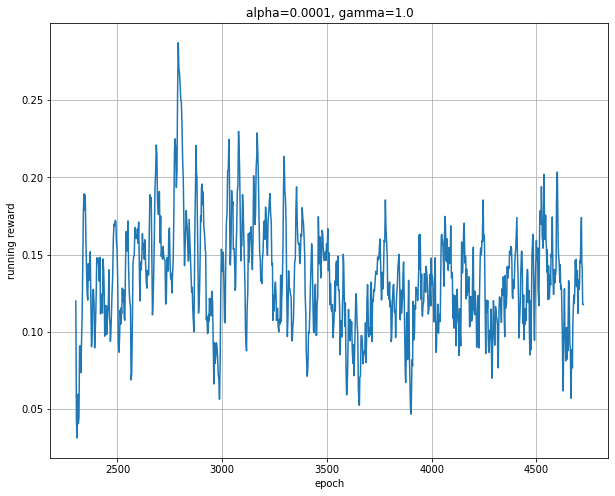

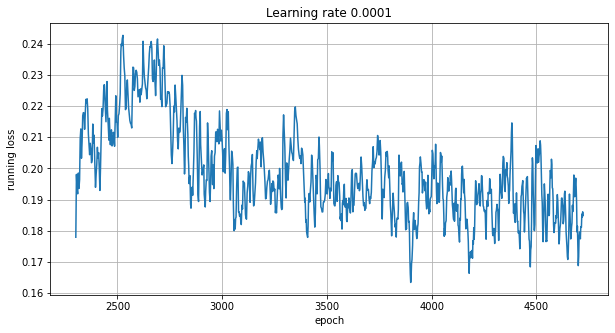

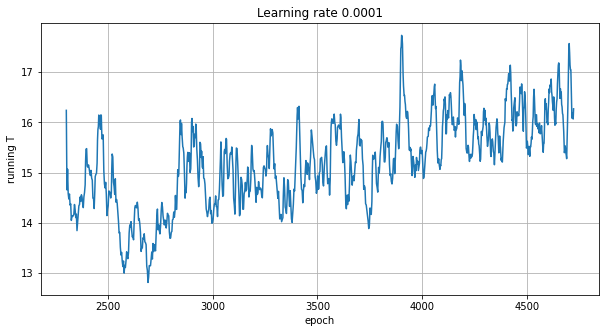

In [4]:
%matplotlib inline

plt.figure().set_size_inches(10,8)
epochs = [ep for ep, rw, loss, rT in stats]
plt.plot(epochs, [rw for ep, rw, loss, rT in stats]) 
plt.grid()
plt.title(f'alpha={alpha}, gamma={gamma}')
plt.ylabel('running reward')
plt.xlabel('epoch')
plt.show()

plt.figure().set_size_inches(10,5)
epochs = [ep for ep, rw, loss, rT in stats]
plt.plot(epochs, [loss for ep, rw, loss, rT in stats]) 
plt.grid()
plt.title('Learning rate ' + str(alpha))
plt.ylabel('running loss')
plt.xlabel('epoch')
plt.show()

plt.figure().set_size_inches(10,5)
epochs = [ep for ep, rw, loss, rT in stats]
plt.plot(epochs, [rT for ep, rw, loss, rT in stats]) 
plt.grid()
plt.title('Learning rate ' + str(alpha))
plt.ylabel('running T')
plt.xlabel('epoch')
plt.show()


### Evaluation
Play a game:

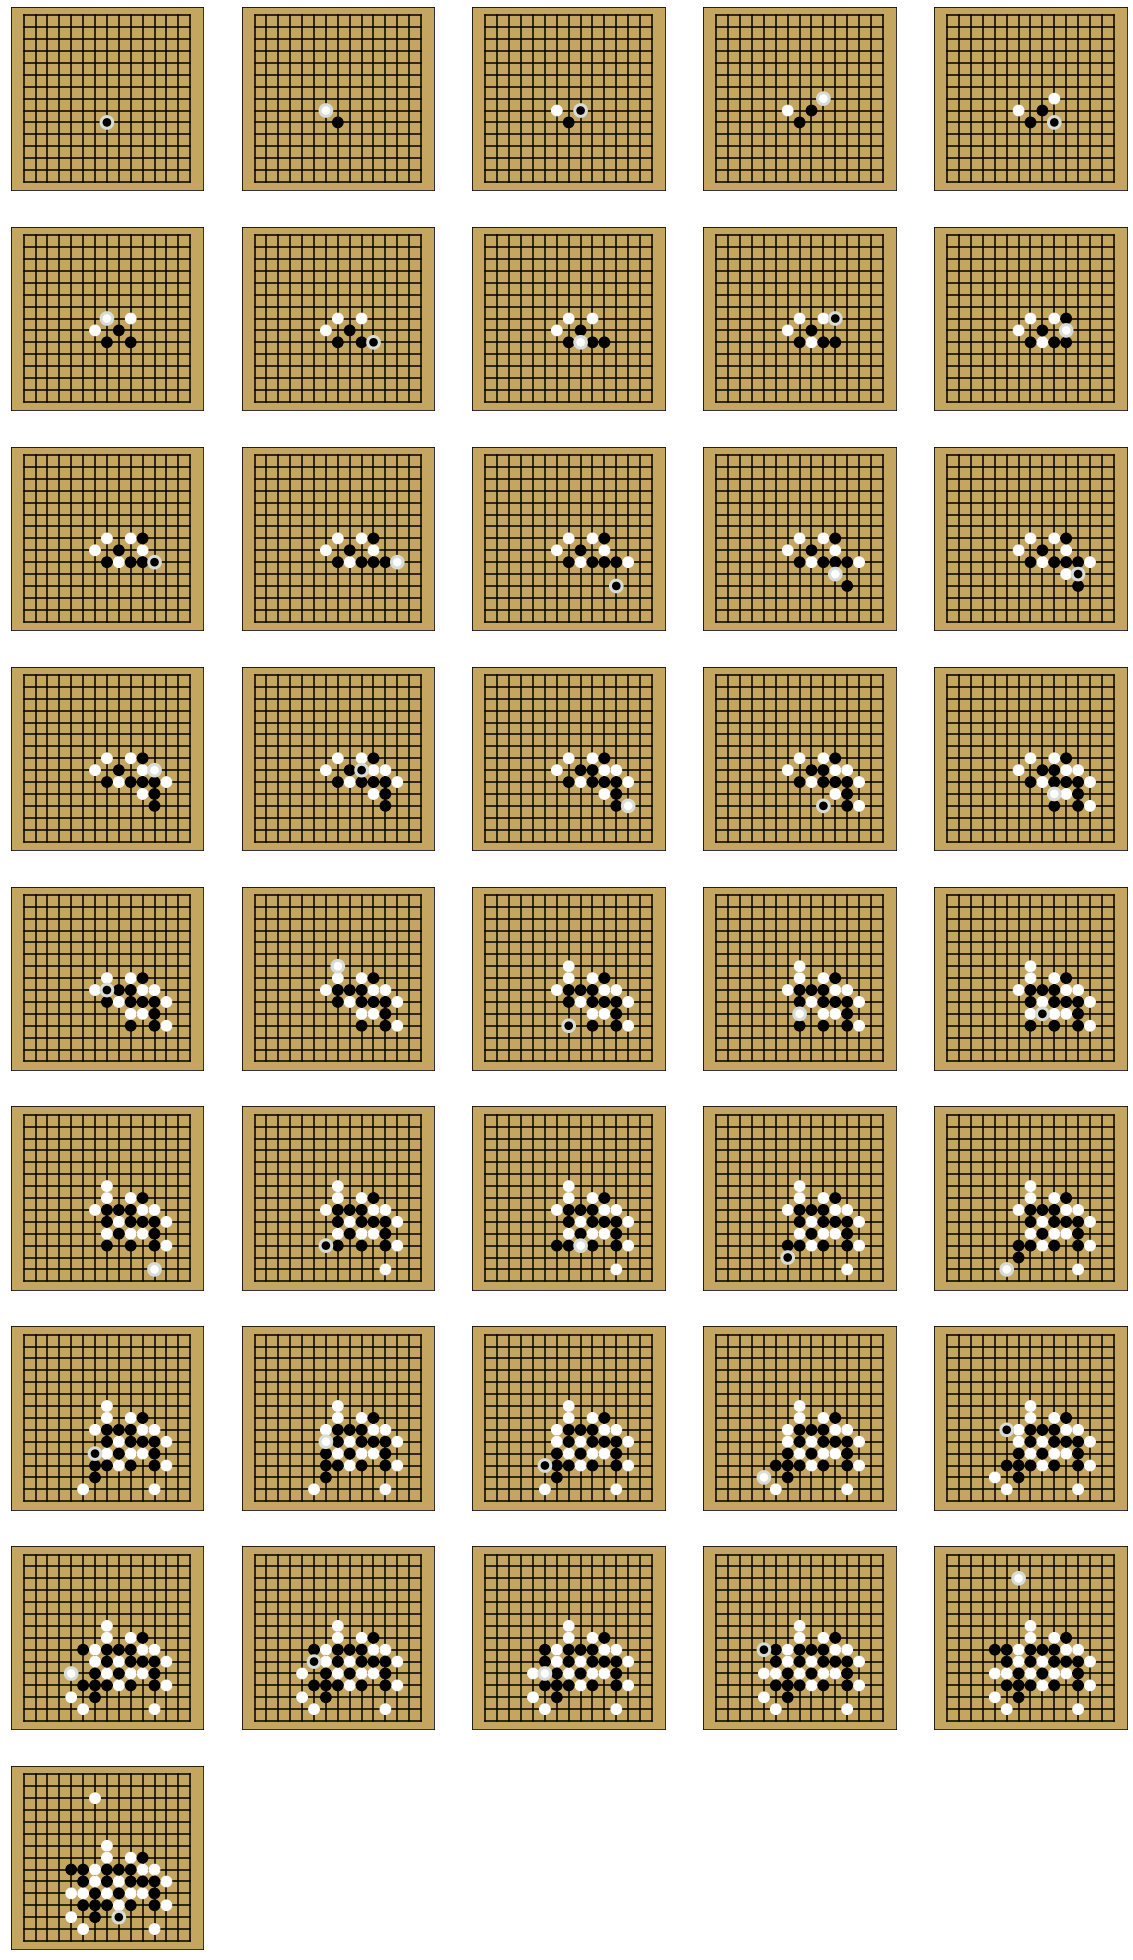

In [7]:
%matplotlib inline
gp.play_a_game(model, model, player_exploration=0.0, player_max_factor=100.0, opp_exploration=0.0, opp_max_factor=50.0)